In [1]:
import numpy as np
import xgboost as xgb
import mplhep as hep
import matplotlib.pyplot as plt
import os
from numba_stats import expon # crystalball,crystalball_ex, norm, expon, voigt, truncexpon


os.environ["HOMELUDO"] = '/home/submit/mori25/'
os.environ["DPUSER"] = '/work/submit/mori25/Darkphotons_ludo/offline_analysis'

from training_offline import Trainer, plot_ROC,plot_ROC_train_test 

In [2]:
modelname = "forest_prompt"
Jpsi_fp = Trainer("Jpsi", modelname)
Jpsi_fp.load_data(trigger="HLT_DoubleMu4_3_LowMass",include_MC=True)
Jpsi_fp.prepare_training_set(prompt_reweight=True)
Jpsi_fp.load_model()




Start loading data


Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Jpsi/merged_A.root to memory
Start loading MC data
Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/MC_InclusiveMinBias/Jpsi/merged_A.root to memory
sig_lims: [[3.0886, 3.0986]]
Start fitting function  <function nonPrompt_tail at 0x7fa59e698d60> to variable  Mm_kin_lxy
Done fitting. Parameters:  270.4246890385895 0.16333152998676784

Some General infos:

                Total number of events considered: 286963 

                Sum of weights: 184939.28111708496 

                Fitted prompt: 183852.88560635553

                Sum of weights>0 184939.28111708496


Threw 0.03673306344954449 of bkg events
Total signal events: 286963
Total signal weight: 184939.28111708496, 0.66 of total weight
Defined training and evaluation datasets
loading model  /work/submit/mori25/Darkphotons_ludo/offline_analysis/BDT/trained_models/forest_prompt_Jpsi.json
loading successful


Now look for optimal discriminators

In [3]:
Jpsi_fp.val_bkg=Jpsi_fp.bst.predict(xgb.DMatrix(Jpsi_fp.X_val[Jpsi_fp.y_val==0]))
Jpsi_fp.val_sig=Jpsi_fp.bst.predict(xgb.DMatrix(Jpsi_fp.X_val[Jpsi_fp.y_val==1]))

Start by optimizing only the BDT cut. Assume reweighing 

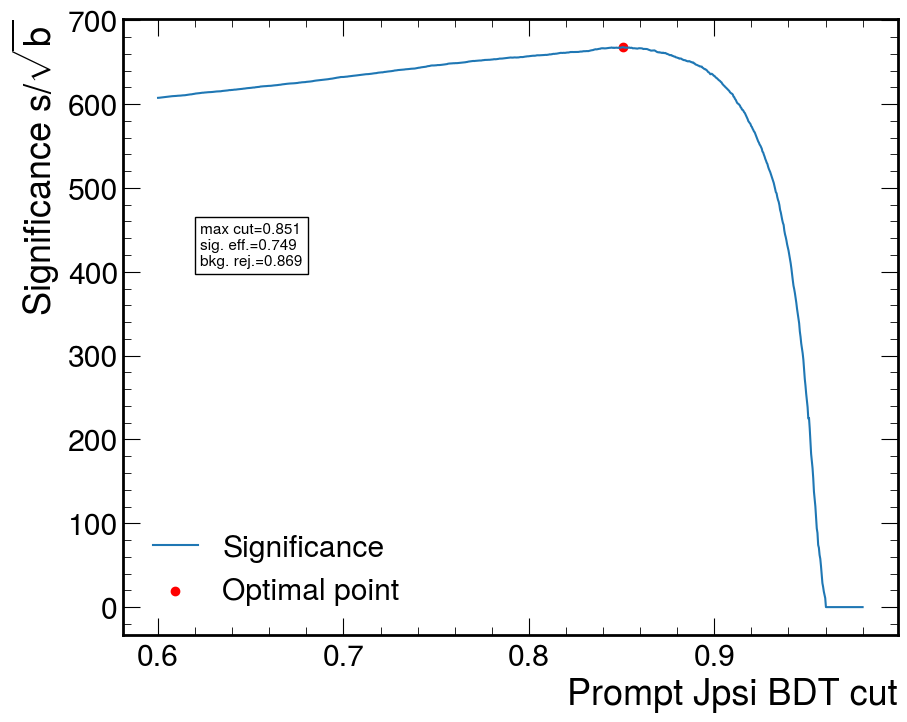

In [8]:
def significance(dis_lim):
    sig = Jpsi_fp.weights[Jpsi_fp.X_val.index[Jpsi_fp.y_val==1]][Jpsi_fp.val_sig > dis_lim]
    s = np.sum(sig)
    bkg = Jpsi_fp.weights[Jpsi_fp.X_val.index[Jpsi_fp.y_val==0]][Jpsi_fp.val_bkg > dis_lim]
    b = np.sum(bkg)
    r = s/np.sqrt(b) if b!= 0 else 0
    return r,s,b

stot = np.sum(Jpsi_fp.weights[Jpsi_fp.X_val.index[Jpsi_fp.y_val==1]])
btot = np.sum(Jpsi_fp.weights[Jpsi_fp.X_val.index[Jpsi_fp.y_val==0]])

xlims = 0.6,0.98
BDT_vals= np.linspace(*xlims,1000)
significance_vals = np.vectorize(significance)(BDT_vals)
max_idx = np.argmax(significance_vals[0])
max_cut = BDT_vals[max_idx]
max_significance = significance_vals[0][max_idx]
sig_eff = significance_vals[1][max_idx]/stot
bkg_rej = 1 - significance_vals[2][max_idx]/btot
text = f"max cut={round(max_cut,3)}\nsig. eff.={round(sig_eff,3)}\nbkg. rej.={round(bkg_rej,3)}"


hep.style.use("CMS")
plt.figure(figsize=(10, 8))
plt.plot(BDT_vals, significance_vals[0],label="Significance")
plt.scatter([max_cut],[max_significance],label="Optimal point",c='red')
plt.xlabel('Prompt Jpsi BDT cut')
plt.ylabel('Significance $s/\sqrt{b}$')
plt.legend()
ax = plt.gca()
plt.text(0.1,0.6,text, fontsize=11, bbox=dict(facecolor='white', edgecolor='black'),transform=ax.transAxes) 
plt.show()

Now same for MuonID

In [5]:
id1=Jpsi_fp.trainData["Muon_softMva1"][Jpsi_fp.X_val.index]
id2=Jpsi_fp.trainData["Muon_softMva2"][Jpsi_fp.X_val.index]
sig_cut = Jpsi_fp.trainData["Score"][Jpsi_fp.X_val.index]==1
bkg_cut = Jpsi_fp.trainData["Score"][Jpsi_fp.X_val.index]==0

print(sum(sig_cut))

81780


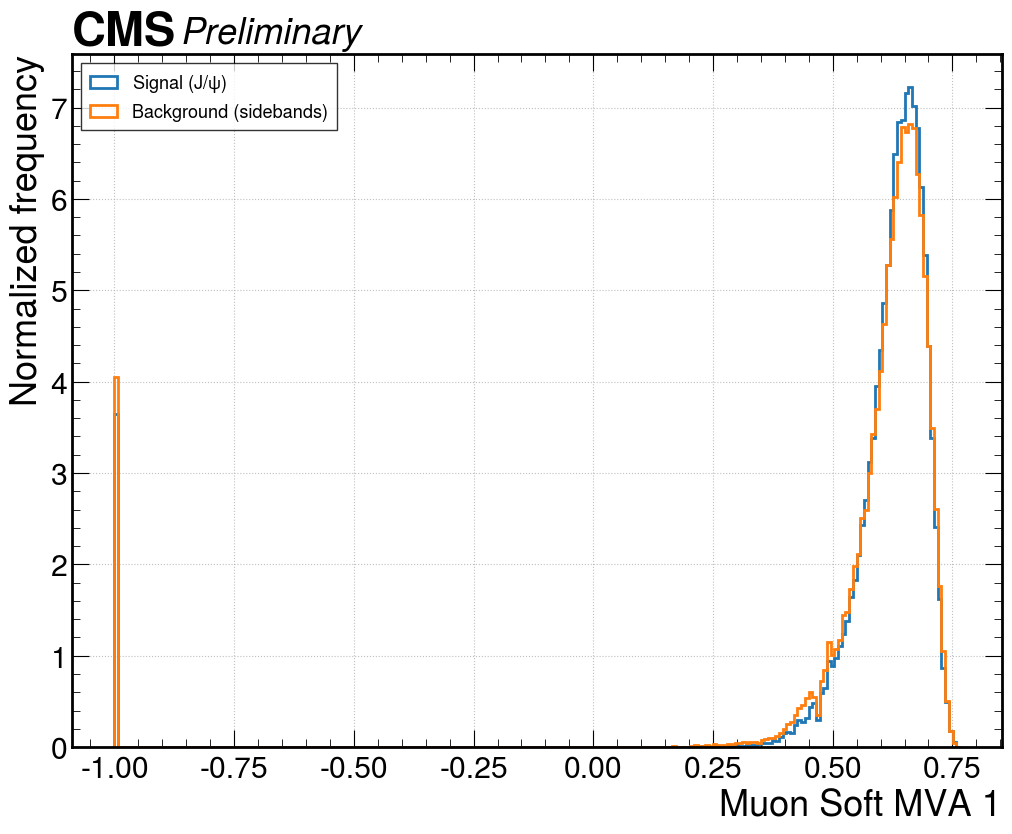

In [6]:
Jpsi_fp.plot_hist([id2[sig_cut],id2[bkg_cut],id2[sig_cut],id2[bkg_cut]][:2],["Signal ($J/\psi$)","Background (sidebands)","Signal rew.","Background rew."],  weights=[None,None,Jpsi_fp.weights[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],Jpsi_fp.weights[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0]],
                  xlim=None, xlabel = "Muon Soft MVA 1",nbins=229,density=True)

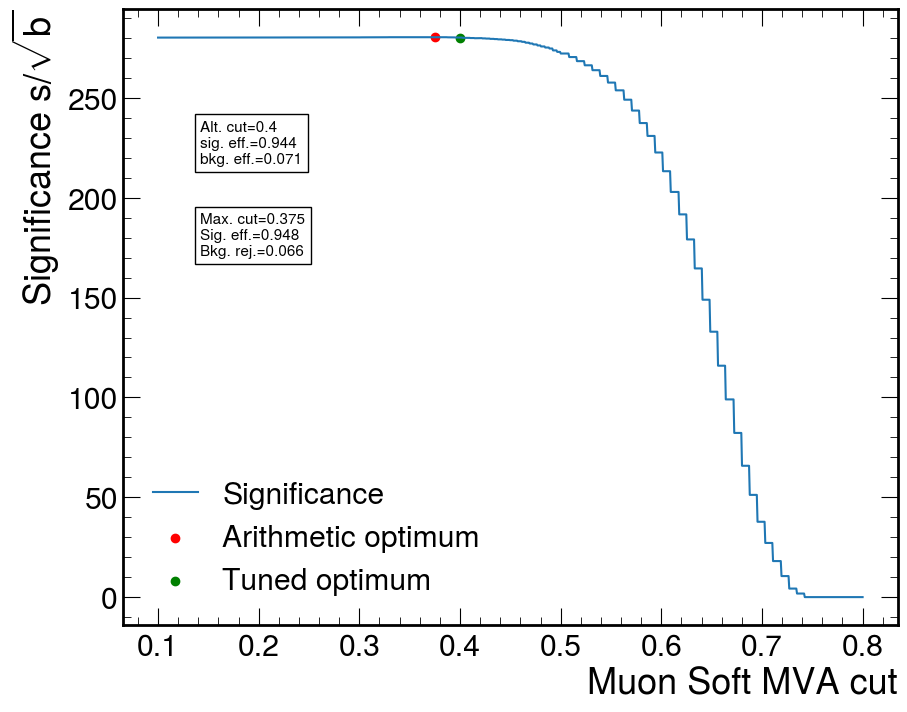

In [7]:
def IDsignificance(dis_lim):
    sig = (id1[sig_cut] > dis_lim) & (id2[sig_cut] > dis_lim)
    s = np.sum(sig)
    bkg = (id1[bkg_cut] > dis_lim) & (id2[bkg_cut] > dis_lim)
    b = np.sum(bkg)
    r = s/np.sqrt(b) if b!= 0 else 0
    return r,s,b

stot = np.sum(Jpsi_fp.y_val==1)
btot = np.sum(Jpsi_fp.y_val==0)

xlims = 0.1,0.8
MuonID_vals= np.linspace(*xlims,1000)
significance_vals = np.vectorize(IDsignificance)(MuonID_vals)

max_idx = np.argmax(significance_vals[0])
max_cut = MuonID_vals[max_idx]
max_significance = significance_vals[0][max_idx]
sig_eff = significance_vals[1][max_idx]/stot
bkg_rej = 1 - significance_vals[2][max_idx]/btot
text = f"Max. cut={round(max_cut,3)}\nSig. eff.={round(sig_eff,3)}\nBkg. rej.={round(bkg_rej,3)}"

alt_cut = 0.4
alt_significance = significance_vals[0][np.argmin(np.abs(MuonID_vals-alt_cut))]
sig_eff_alt = significance_vals[1][np.argmin(np.abs(MuonID_vals-alt_cut))]/stot
bkg_eff_alt = 1 - significance_vals[2][np.argmin(np.abs(MuonID_vals-alt_cut))]/btot
text_alt = f"Alt. cut={round(alt_cut,3)}\nsig. eff.={round(sig_eff_alt,3)}\nbkg. eff.={round(bkg_eff_alt,3)}"

hep.style.use("CMS")
plt.figure(figsize=(10, 8))
plt.plot(MuonID_vals, significance_vals[0],label="Significance")
plt.scatter([max_cut],[max_significance],label="Arithmetic optimum",c='red')
plt.scatter([alt_cut],[alt_significance],label="Tuned optimum",c='green')
plt.xlabel('Muon Soft MVA cut')
plt.ylabel('Significance $s/\sqrt{b}$')
plt.legend()
ax = plt.gca()
plt.text(0.1,0.6,text, fontsize=11, bbox=dict(facecolor='white', edgecolor='black'),transform=ax.transAxes) 
plt.text(0.1,0.75,text_alt, fontsize=11, bbox=dict(facecolor='white', edgecolor='black'),transform=ax.transAxes) 
plt.show()